# Softmax exercise

We will implement a softmax classifier that is trained on the CIFAR10 dataset. The output is a model that is able to classify the input image into the 10 different classes of the CIFAR10 dataset.

Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- use a validation set to **tune the learning rate** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from random import shuffle

from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform
from torchvision import datasets


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset

In [3]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  datasets.CIFAR10(
        root="data/", train=True,
        download=True, transform=None,
    )
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  return Xtr, Ytr

    
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'
    X_train, y_train = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # Normalize the data: subtract the mean image and divide by variance
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    X_train = np.divide(np.subtract( X_train/255 , mean[np.newaxis,np.newaxis,:]), std[np.newaxis,np.newaxis,:])
    X_val = np.divide(np.subtract( X_val/255 , mean[np.newaxis,np.newaxis,:]), std[np.newaxis,np.newaxis,:])

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)


## Softmax Classifier

Here, you implement **softmax_loss_vectorized**. This function just returns the loss and gradient after applying the softmax function.


In [4]:
def softmax_loss_vectorized(W, X, y):
    """
    Softmax loss function, vectorized version.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability.                         #
    #############################################################################

    # array dimensions
    N = np.size(X, axis=0)

    # Score for some W (linear): s = f(x,W) = X * W # [N x C] = [N x D] x [D x C]
    s = np.dot(X, W)                                # [N x C] = [N x D] x [D x C]
    s = s-np.max(s, axis=1, keepdims=True)          # normalization to avoid numerical instability during division by large exponential term
    exp_s = np.exp(s)                               # [N x C]

    # Probability that sample i within [0 N-1] belongs to class k within [0 C-1]: P(Y=k|X=x_i)
    P = exp_s/np.sum(exp_s, axis=1, keepdims=True)  # [N x C] = [N x C] / [N x 1]
    # or (exp_s.T/np.sum(exp_s, axis=1).T).T

    # Loss Function
    # Maximum Log-Likelyhood (correct classification): L_i = -log(P(Y=y_i|X=x_i))
    L_i = -np.log(P[np.arange(N),y])                # [N x 1]
    loss = np.sum(L_i)/N                            # [1 x 1]
    
    # Gradient
    # ds = dL_i/ds_j = P - (y_i==j)
    ds = P                                          # [N x C]
    ds[np.arange(N),y] -= 1                         # [N x C]

    # dW = dL/dW_j = ds_j/dW_j * dL/ds_j = ds_j/dW_j * 1/N * dL_i/ds_j = X^T * 1/N * (P - (y_i==j))
    dW = np.dot(np.transpose(X), ds) / N                   # [D x C] = [D x N] x [N x C] / [1 x 1]

    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW

## This is the Softmax Linear Classifier.
### Implement SGD in the train function.
### Write the predict function to evaluate the performance on both the training and validation set
### Do not touch the loss function. You already defined it above.

In [5]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
            training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
            means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            
            indices = np.random.choice(np.arange(num_train), size=batch_size)
            X_batch = X[indices,:]
            y_batch = y[indices]
            
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            
            self.W -= learning_rate*grad

            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
        training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
        array of length N, and each element is an integer giving the predicted
        class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        
        s = np.dot(X, self.W)                           # [N x C] = [N x D] x [D x C]
        s = s-np.max(s, axis=1, keepdims=True)          # normalization to avoid numerical instability during division by large exponential term
        exp_s = np.exp(s)                               # [N x C]

        # Probability that sample i within [0 N-1] belongs to class k within [0 C-1]: P(Y=k|X=x_i)
        P = exp_s/np.sum(exp_s, axis=1, keepdims=True)  # [N x C] = [N x C] / [N x 1]

        # Predicted Class Label
        y_pred = np.argmax(P, axis=1)

        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred
  
    def loss(self, X_batch, y_batch):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
            data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass
        

Finally, the softmax class is inherited from LinearClassifier and uses the softmax_loss_vectorized function as its loss:

In [6]:
class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch):
        return softmax_loss_vectorized(self.W, X_batch, y_batch)

In [7]:
W = np.random.randn(3073, 10) * 0.0001
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_val, y_val)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

vectorized loss: 2.303241e+00 computed in 0.031726s


In [8]:
# Use the validation set to tune hyperparameters (learning rate). 
# You should experiment with different ranges for the learning
# rates; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-4, 5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3] # original: [1e-7, 5e-4]
# learning_rates = np.logspace(-5, -2, num=40) # find best range

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning.                                  #
# Save the best trained softmax classifer in best_softmax.                     #
################################################################################

nb_iters = 100
loss_history_training = np.zeros([nb_iters, len(learning_rates)])

for lr, lr_idx in zip(learning_rates, np.arange(len(learning_rates))):
  sm = Softmax()

  # Train Softmax model only on training set, keep validation set for testing
  loss_history_training[:, lr_idx] = sm.train(X_train, y_train, learning_rate=lr, num_iters=nb_iters, batch_size=200, verbose=False)

  # Predicted labels of training and validation dataset
  y_train_pred = sm.predict(X_train)
  y_val_pred = sm.predict(X_val)

  # Save training and validation accuracy into results
  training_accuracy = np.mean(y_train == y_train_pred)
  validation_accuracy = np.mean(y_val == y_val_pred)
  results[lr] = [training_accuracy, validation_accuracy]
  
  # Save best softmax model on validation set
  if validation_accuracy > best_val:
    best_val = validation_accuracy
    best_softmax = sm  

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr in sorted(results):
    train_accuracy, val_accuracy = results[lr]
    print('lr %e train accuracy: %f val accuracy: %f' % (
                lr, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-04 train accuracy: 0.264449 val accuracy: 0.268000
lr 5.000000e-04 train accuracy: 0.316776 val accuracy: 0.326000
lr 1.000000e-03 train accuracy: 0.342837 val accuracy: 0.349000
lr 2.500000e-03 train accuracy: 0.359939 val accuracy: 0.377000
lr 5.000000e-03 train accuracy: 0.379224 val accuracy: 0.377000
lr 7.500000e-03 train accuracy: 0.373653 val accuracy: 0.383000
best validation accuracy achieved during cross-validation: 0.383000


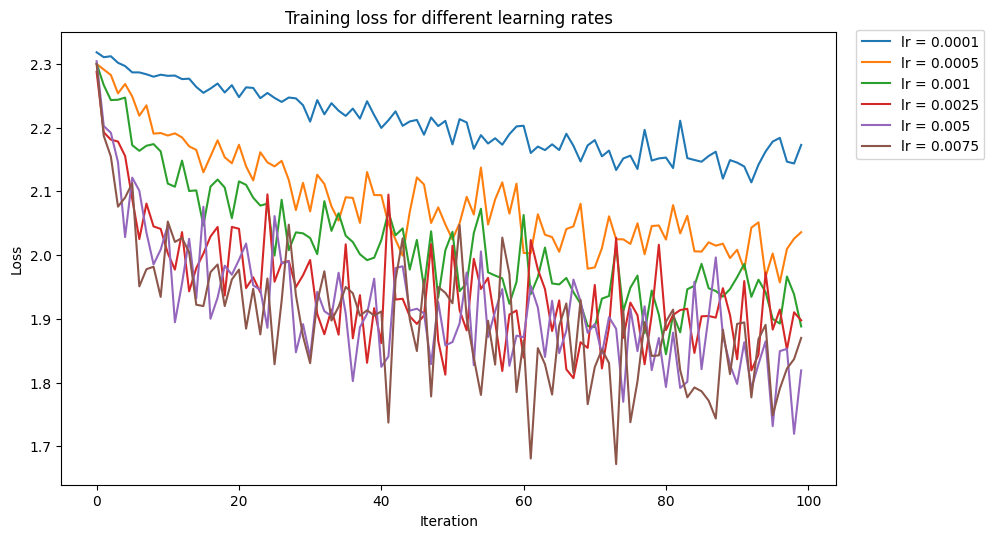

In [14]:
for lr, lr_idx in zip(learning_rates, np.arange(len(learning_rates))):
  # Plotting the loss history for different learning rates
  plt.plot(np.arange(nb_iters), loss_history_training[:, lr_idx], label='lr = '+str(lr))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training loss for different learning rates")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.legend(bbox_to_anchor = (1.2, 1.02))
plt.show() # Load the display window

In [10]:
# evaluate on val set
# Evaluate the best softmax on val set
y_val_pred = best_softmax.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('softmax on raw pixels final test set accuracy: %f' % (val_accuracy, ))

softmax on raw pixels final test set accuracy: 0.383000


Save the best_softmax weights using pickle:

In [11]:
with open('drive/MyDrive/Colab Notebooks/tp_2/softmax_weights.pkl', 'wb') as f:
    pickle.dump(best_softmax.W, f)

Load the best_softmax weights using pickle:

In [12]:
with open('drive/MyDrive/Colab Notebooks/tp_2/softmax_weights.pkl', 'rb') as f:
    W = pickle.load(f)
new_softmax = Softmax()
new_softmax.W = W.copy()

Below is the code to visualize the weights learned for different classes. Try to notice the interesting patterns.

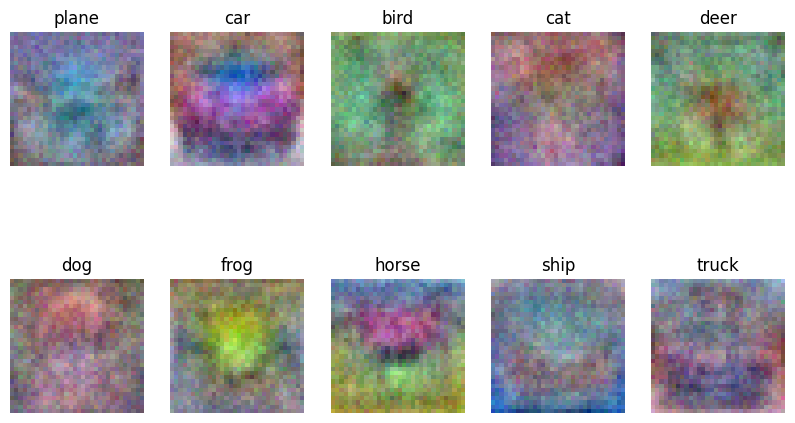

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])